## TM-TV exercise

### 0. import resources

In [102]:
import nltk 
import spacy

from collections import defaultdict
#import csv
import ast
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora, similarities, utils
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

from sklearn.datasets import fetch_20newsgroups

import matplotlib.colors as mcolors
from wordcloud import WordCloud

warnings.filterwarnings('ignore') # setting ignore as a parameter

nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')

print("Libraries imported successfully!")

Libraries imported successfully!


1. Create the corpus -> dictionary with frequency of words for each document and dictionary with tags associated (for further analysis)

1.1 Choose documents

1.2 Pre processing

1.3 Create the dictionary with frequencies 

In [103]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True, remove=('headers', 'footers', 'quotes'))

texts = newsgroups_train.data
targets = newsgroups_train.target
texts_test = newsgroups_test.data
targets_test = newsgroups_test.target
print(list(newsgroups_train.target_names))

print(newsgroups_train.data[:2])

print(len(texts))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.', "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Pleas

2. Create the model 

2.1 Pre processing

2.2 Building Dictionary & Corpus for Topic Model

2.3 Building LDA Topic Model

In [104]:
# Tokenization

def texts_to_tokens(texts: list): 
     texts_token = []
     texts = [text.replace("\n", " ") for text in texts]
     docs = list(nlp.pipe(texts, disable=['ner']))
     for doc in docs:
          text_tokens = [token.lemma_ for token in doc if len(token.text) > 2 and token.is_alpha and \
               token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and not token.is_punct and not token.is_stop]
          text_tokens = list(set(text_tokens))
          texts_token.append(text_tokens)

     return texts_token

def add_bigrams(texts_token: list):
     bigram = Phrases(texts_token, min_count=5, threshold=100, connector_words=ENGLISH_CONNECTOR_WORDS)
     for idx in range(len(texts_token)):
          for token in bigram[texts_token[idx]]:
               if '_' in token and token not in texts_token[idx]:
                    texts_token[idx].append(token)

     return texts_token

texts_token = texts_to_tokens(texts)
print("Tokenization done!")
texts_token = add_bigrams(texts_token)
print("added bigrams!")

Tokenization done!
added bigrams!


In [97]:

print(texts_token[:2])

[['year', 'small', 'tellme', 'early', 'funky', 'enlighten', 'car', 'know', 'history', 'door', 'sport', 'addition', 'rest', 'wonder', 'separate', 'look', 'day', 'engine', 'mail', 'production', 'call', 'body', 'see', 'spec', 'model', 'info', 'bumper', 'late'], ['fair', 'heat', 'send', 'sink', 'hour', 'thank', 'share', 'usage', 'rate', 'answer', 'brave', 'message', 'request', 'summarize', 'knowledge', 'clock', 'attain', 'card', 'network', 'floppy', 'speed', 'oscillator', 'experience', 'day', 'disk', 'functionality', 'number', 'especially', 'adapter', 'procedure', 'upgrade', 'add', 'brief', 'detail', 'soul', 'poll', 'base']]


In [99]:
dictionary = corpora.Dictionary(texts_token)
dictionary.filter_extremes(no_below=50, no_above=0.2, keep_n= 100000)

In [100]:
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary, random_state=100)
lda_model.show_topics()

[(0,
  '0.010*"know" + 0.007*"thank" + 0.007*"use" + 0.006*"look" + 0.006*"want" + 0.005*"think" + 0.005*"new" + 0.005*"need" + 0.005*"system" + 0.005*"good"'),
 (1,
  '0.006*"people" + 0.006*"think" + 0.005*"know" + 0.004*"good" + 0.004*"say" + 0.004*"come" + 0.004*"time" + 0.004*"way" + 0.004*"thing" + 0.003*"believe"'),
 (2,
  '0.003*"drain" + 0.003*"end" + 0.003*"swiss" + 0.003*"run" + 0.003*"think" + 0.003*"thing" + 0.003*"water" + 0.003*"copper" + 0.002*"disclose" + 0.002*"diamond"'),
 (3,
  '0.004*"time" + 0.004*"year" + 0.004*"want" + 0.004*"know" + 0.004*"people" + 0.004*"problem" + 0.003*"say" + 0.003*"thing" + 0.003*"find" + 0.003*"good"'),
 (4,
  '0.009*"problem" + 0.009*"thank" + 0.008*"run" + 0.008*"know" + 0.008*"work" + 0.008*"try" + 0.007*"window" + 0.007*"use" + 0.007*"file" + 0.007*"drive"'),
 (5,
  '0.006*"program" + 0.005*"file" + 0.005*"use" + 0.005*"help" + 0.004*"soon" + 0.004*"work" + 0.004*"available" + 0.004*"find" + 0.003*"include" + 0.003*"need"'),
 (6,
  '

3. Visualizations of the model 

In [101]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031442 -0.113694       1        1  35.499571
0      0.080045  0.037011       2        1  20.766641
3      0.035383 -0.048751       3        1  15.526614
4      0.063329  0.106143       4        1   9.270833
7     -0.020254 -0.064356       5        1   7.018648
5      0.023006  0.059239       6        1   6.480305
6     -0.030504 -0.017098       7        1   4.427529
2     -0.182446  0.041506       8        1   1.009858, topic_info=      Term         Freq        Total Category  logprob  loglift
213  think  2394.000000  2394.000000  Default  30.0000  30.0000
61   thank  1400.000000  1400.000000  Default  29.0000  29.0000
302    run  1020.000000  1020.000000  Default  28.0000  28.0000
206   file   595.000000   595.000000  Default  27.0000  27.0000
141    use  1774.000000  1774.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
87     get     9.508489  1345.773777   Topic8  -6.2375  -0.3572
166  right     9.038249  1209.729982   Topic8  -6.2882  -0.3013
4      car     8.621028   473.062776   Topic8  -6.3355   0.5903
13    know     8.999561  2769.869002   Topic8  -6.2925  -1.1340
191  point     8.701494  1144.990537   Topic8  -6.3262  -0.2843

[706 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
216       2  0.024536      SCSI
216       3  0.024536      SCSI
216       4  0.907821      SCSI
766       1  0.026539  accuracy
766       2  0.875794  accuracy
...     ...       ...       ...
27        5  0.106714      year
27        6  0.027016      year
27        7  0.060111      year
27        8  0.003377      year
5888      1  0.946570   zionist

[2267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 8, 6, 7, 3])

In [82]:
for i in range(len(texts)):
    print(lda_model[corpus][i])

[(0, 0.51881844), (4, 0.35457054), (6, 0.104575)]
[(0, 0.117778145), (3, 0.16372004), (4, 0.46230265), (7, 0.24301906)]
[(0, 0.66377735), (3, 0.088726014), (4, 0.042440772), (6, 0.1994377)]
[(0, 0.87488073), (1, 0.017870001), (2, 0.017867224), (3, 0.017877325), (4, 0.017879821), (5, 0.017885718), (6, 0.0178734), (7, 0.017865773)]
[(0, 0.96751404)]
[(1, 0.97009134)]
[(1, 0.21740651), (4, 0.75008476)]
[(0, 0.2075905), (3, 0.055381738), (4, 0.72338307)]
[(0, 0.012520512), (1, 0.0125213545), (2, 0.012516507), (3, 0.012513451), (4, 0.9123127), (5, 0.012515185), (6, 0.012557666), (7, 0.012542668)]
[(3, 0.42317614), (4, 0.5579979)]
[(0, 0.36034405), (7, 0.6118292)]
[(1, 0.63374907), (4, 0.25965708), (7, 0.10086648)]
[(0, 0.125), (1, 0.125), (2, 0.125), (3, 0.125), (4, 0.125), (5, 0.125), (6, 0.125), (7, 0.125)]
[(0, 0.7082395), (1, 0.04384141), (5, 0.17624687), (6, 0.06791689)]
[(0, 0.34768665), (1, 0.63618606)]
[(3, 0.9031096), (6, 0.07176233)]
[(1, 0.40053952), (5, 0.5889847)]
[(0, 0.400001

4. Evaluation of the model

In [83]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts_token, dictionary=dictionary,
                                     coherence='u_mass', processes=3)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.833408999862831

Coherence Score:  -2.691402158429438


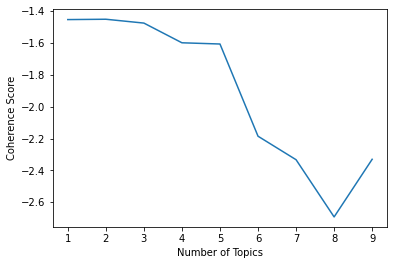

In [84]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [84]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, id2word=dictionary,num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, texts = texts_token, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

4. Analysis of the topics using target

In [85]:
topics = [sorted(lda_model[corpus][text], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(texts))]

topics_df = pd.DataFrame(topics, columns=['topic'])
topics_df['topic'].value_counts().sort_index()
#print(lda_model[corpus][2])

#print(sorted(lda_model[corpus][2], key=lambda x: x[1], reverse=True))

0    3394
1    3066
2     108
3    1216
4    1552
5     584
6     495
7     899
Name: topic, dtype: int64

In [86]:
y_topic = topics_df['topic'].values
lda_topics = lda_model.show_topics(formatted=False)

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_topics]

for text in range(len(texts)): 
    print("Text: ", text)
    print("Result model: ", lda_topics[y_topic[text]])
    print("Real tags: ", targets[text])

Text:  0
Result model:  ['know', 'thank', 'use', 'look', 'want', 'think', 'new', 'need', 'system', 'good']
Real tags:  7
Text:  1
Result model:  ['problem', 'thank', 'run', 'know', 'work', 'try', 'window', 'use', 'file', 'drive']
Real tags:  4
Text:  2
Result model:  ['know', 'thank', 'use', 'look', 'want', 'think', 'new', 'need', 'system', 'good']
Real tags:  4
Text:  3
Result model:  ['know', 'thank', 'use', 'look', 'want', 'think', 'new', 'need', 'system', 'good']
Real tags:  1
Text:  4
Result model:  ['know', 'thank', 'use', 'look', 'want', 'think', 'new', 'need', 'system', 'good']
Real tags:  14
Text:  5
Result model:  ['people', 'think', 'know', 'good', 'say', 'come', 'time', 'way', 'thing', 'believe']
Real tags:  16
Text:  6
Result model:  ['problem', 'thank', 'run', 'know', 'work', 'try', 'window', 'use', 'file', 'drive']
Real tags:  13
Text:  7
Result model:  ['problem', 'thank', 'run', 'know', 'work', 'try', 'window', 'use', 'file', 'drive']
Real tags:  3
Text:  8
Result mode

Unseen documents

In [93]:
# Data preprocessing step for the unseen document
#texts_test = texts_to_tokens(texts_test)
bow_vector = dictionary.doc2bow((texts_test))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


TypeError: decoding to str: need a bytes-like object, list found

### Wordcloud

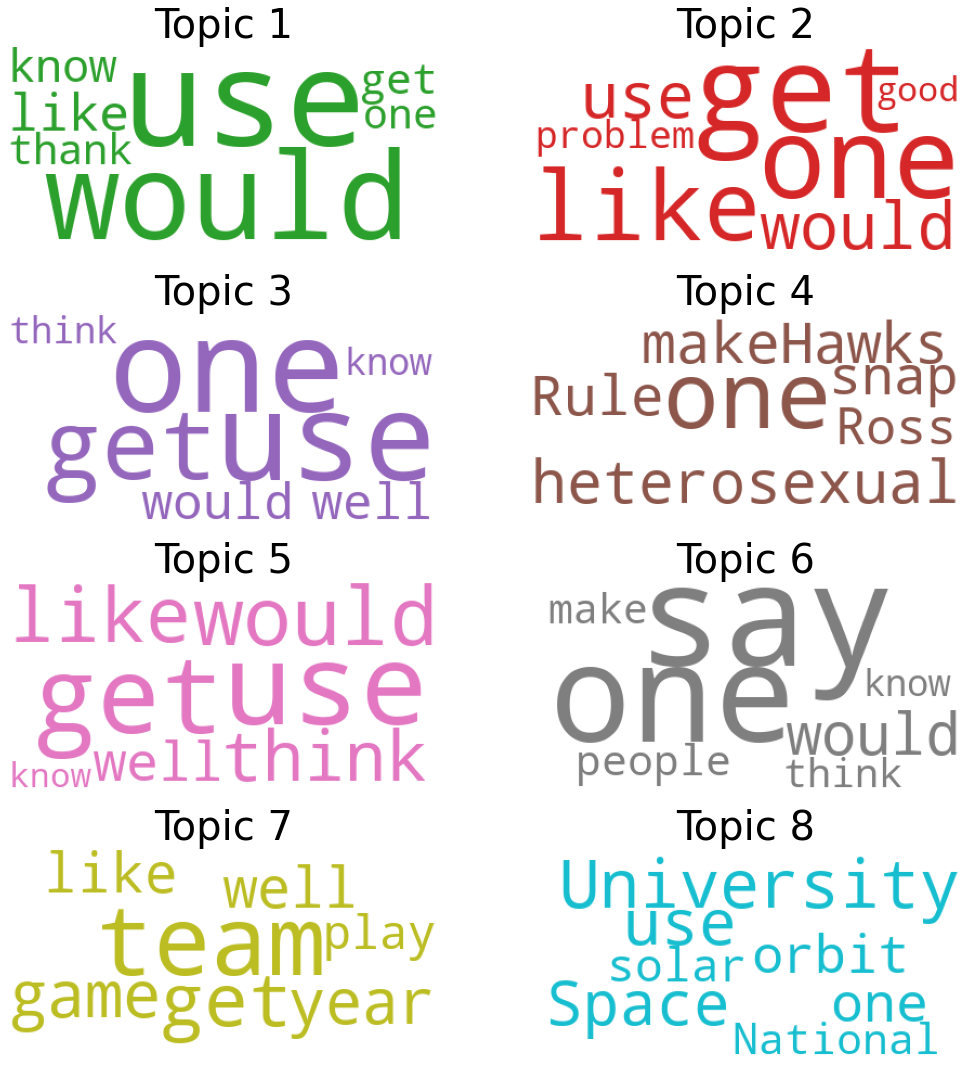

In [45]:
cols = list(mcolors.TABLEAU_COLORS.values())

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  color_func=lambda *_, **kwargs: cols[-8+i],
                  max_words=7,
                  prefer_horizontal=True)

topics = lda_model.show_topics(formatted=False, num_topics=8, num_words=7)
fig, axes = plt.subplots(4, 2, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().axis('off')
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', font=dict(size=40))

plt.tight_layout()
plt.show()

In [ ]:
path = f'resources/inshort_news_data-5.csv'
path_corpus = f'resources/corpus.txt'
path_target = f'resources/target.txt'
features = []

def load_corpus():
    if not os.path.exists(path_corpus):
        texts = []
        targets = []

        with open(path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            i = 0
            for article in reader:
                if i == 0: 
                    features = article.insert(0, "id")
                    i += 1
                else:
                    text = article[2].replace("\n", " ")
                    texts.append(text)
                    target = article[3]
                    targets.append(target)
                    i += 1
    
        with open (path_corpus, 'w', encoding='utf-8') as f:
            for text in texts:
                f.write('"'+text+'"'+"\n")

        with open (path_target, 'w', encoding='utf-8') as f:
            for target in targets:
                f.write(target+"\n")
    else: 
        
        texts = []
        with open(path_corpus, 'r', encoding='utf-8') as f:
            texts = f.readlines()
            texts = [text.replace('"', '') for text in texts]

        targets = []
        with open(path_target, 'r', encoding='utf-8') as f:
            targets = f.readlines()
    
    return texts, targets

texts, targets = load_corpus()

n_topics = len(list(set(targets)))

print("Number of topics: ", n_topics)

print("Distribution topics: ", dict(pd.Series(targets).value_counts()))